In [172]:
from sklearn.preprocessing import LabelEncoder

labels = [
    "entertainment",
    "food",
    "travel",
    "health and lifestyle",
    "mom and children",
    "fashion",
    "tech",
    "sports",
    "art",
    "gaming",
]

label_encoder = LabelEncoder()
label_encoder.fit(labels)

LabelEncoder()

In [173]:
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
from consts import *



FILENAME = get_filename(TT.ALL, EMBED_PROVIDER.OPENAI, MEAN_METHOD.CENTROID)
print(FILENAME)

df_embeds = pd.read_parquet(FILENAME)
df_train_all = pd.read_parquet("data/training-dataset.parquet")

df_train = pd.merge(
    df_embeds,
    df_train_all[["username", "category_enum", "label"]],
    how="left",
    on="username",
)
df_train = df_train.dropna(subset=["label"])
df_train = df_train.drop(columns=["username"])
df_train["category_enum"] = df_train["category_enum"].fillna("Missing")

df_train


df_train["target"] = label_encoder.transform(df_train["label"])
df_train = df_train.drop(columns=["label"])


X = df_train.drop(columns=["target"])
y = df_train[["target"]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X.shape)

encoder = TargetEncoder()
cat_encoded_train = encoder.fit_transform(
    X_train["category_enum"].to_numpy().reshape(-1, 1), y_train["target"].tolist()
)
X_train["category_encoded"] = [row.tolist() for row in cat_encoded_train]
X_train = X_train[["embeds_wavg", "category_encoded"]]

X_train = pd.concat(
    [
        pd.DataFrame(X_train["category_encoded"].tolist()),
        pd.DataFrame(X_train["embeds_wavg"].tolist()),
    ],
    axis=1,
)

print(X_train)

cat_encoded_test = encoder.transform(X_test["category_enum"].to_numpy().reshape(-1, 1))
X_test["category_encoded"] = [row.tolist() for row in cat_encoded_test]
X_test = pd.concat(
    [
        pd.DataFrame(X_test["category_encoded"].tolist()),
        pd.DataFrame(X_test["embeds_wavg"].tolist()),
    ],
    axis=1,
)

X_train, X_test, y_train, y_test = (
    X_train.to_numpy(),
    X_test.to_numpy(),
    y_train.to_numpy(),
    y_test.to_numpy(),
)

data/embeddings/openai-t3-large/ue_em_w_centroid.parquet
(2740, 2)
          0         1         2         3         4         5         6     \
0     0.172715  0.000000  0.444561  0.000000  0.000000  0.187196  0.062110   
1     0.000000  0.000000  0.000000  0.000000  0.000000  0.505986  0.000000   
2     0.016611  0.194679  0.082283  0.308666  0.000000  0.148018  0.081372   
3     0.000000  0.015612  0.015607  0.950445  0.000000  0.000000  0.015563   
4     0.000000  0.000000  0.000000  1.000000  0.000000  0.000000  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
2187  0.000000  0.106554  0.249261  0.107441  0.000000  0.273983  0.124626   
2188  0.000000  0.519653  0.154925  0.000000  0.000000  0.000000  0.000000   
2189  0.412791  0.000000  0.202842  0.000000  0.000000  0.000000  0.000000   
2190  0.070696  0.115165  0.107184  0.187001  0.004561  0.182440  0.055872   
2191  0.000000  0.057205  0.110870  0.322355  0.000000  0.113645  0.196621 

In [168]:
import xgboost as xgb
from sklearn.metrics import classification_report

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


# OpeanAI 73
params = {
    "objective": "multi:softmax",
    "num_class": 10,
    "learning_rate": 0.1,
    "max_depth": 4,
    "min_child_weight": 1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_lambda": 1,
    "reg_alpha": 0,
    "device": "cuda",
    "random_state": 42,
    "eval_metric": ["mlogloss", "merror"],
}

evals_result = {}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=150,
    evals=[(dtrain, "train"), (dtest, "test")],
    evals_result=evals_result,
    verbose_eval=True,
)




[0]	train-mlogloss:2.06327	train-merror:0.28239	test-mlogloss:2.12359	test-merror:0.45620
[1]	train-mlogloss:1.88185	train-merror:0.21442	test-mlogloss:1.98757	test-merror:0.37956
[2]	train-mlogloss:1.73421	train-merror:0.18339	test-mlogloss:1.88004	test-merror:0.34307
[3]	train-mlogloss:1.61001	train-merror:0.17016	test-mlogloss:1.79317	test-merror:0.32482
[4]	train-mlogloss:1.49924	train-merror:0.14781	test-mlogloss:1.70947	test-merror:0.32299
[5]	train-mlogloss:1.40160	train-merror:0.13823	test-mlogloss:1.64179	test-merror:0.31387
[6]	train-mlogloss:1.31246	train-merror:0.13139	test-mlogloss:1.58167	test-merror:0.31752
[7]	train-mlogloss:1.23424	train-merror:0.12226	test-mlogloss:1.52406	test-merror:0.30657
[8]	train-mlogloss:1.16519	train-merror:0.11496	test-mlogloss:1.47374	test-merror:0.29927
[9]	train-mlogloss:1.09810	train-merror:0.10493	test-mlogloss:1.42546	test-merror:0.28650
[10]	train-mlogloss:1.03761	train-merror:0.09854	test-mlogloss:1.38564	test-merror:0.28832
[11]	trai

In [169]:
y_pred = model.predict(dtest)
y_pred

array([8., 8., 8., 0., 0., 2., 3., 2., 5., 8., 1., 3., 9., 5., 3., 3., 5.,
       9., 1., 3., 3., 5., 3., 7., 5., 2., 8., 1., 1., 5., 3., 9., 5., 0.,
       3., 0., 1., 1., 3., 8., 5., 8., 6., 3., 2., 0., 1., 3., 1., 2., 8.,
       1., 9., 3., 9., 5., 0., 7., 8., 9., 2., 5., 5., 8., 5., 9., 5., 5.,
       3., 3., 3., 5., 3., 5., 9., 3., 5., 0., 5., 5., 5., 5., 2., 5., 7.,
       2., 8., 8., 5., 8., 5., 5., 1., 2., 9., 5., 0., 1., 6., 5., 9., 3.,
       8., 3., 5., 1., 9., 1., 5., 0., 7., 1., 2., 6., 7., 9., 3., 1., 3.,
       9., 3., 3., 8., 3., 9., 3., 0., 1., 3., 5., 8., 7., 8., 8., 3., 2.,
       1., 7., 3., 5., 1., 8., 8., 5., 5., 5., 8., 7., 2., 3., 0., 9., 9.,
       8., 0., 5., 9., 7., 9., 8., 1., 2., 7., 0., 2., 6., 8., 6., 3., 2.,
       9., 5., 8., 8., 3., 3., 8., 2., 5., 1., 3., 9., 3., 5., 1., 9., 7.,
       3., 2., 3., 5., 1., 3., 3., 9., 1., 3., 1., 1., 5., 0., 5., 2., 6.,
       3., 5., 3., 8., 2., 7., 0., 1., 3., 2., 3., 7., 5., 8., 1., 9., 8.,
       3., 3., 3., 5., 8.

In [170]:
y_pred=y_pred.astype(int).reshape(-1,1)


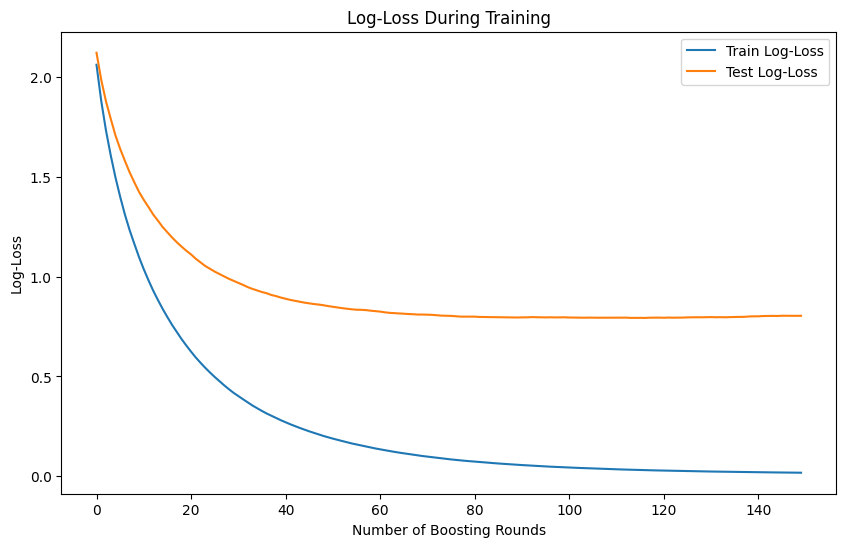


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.36      0.42        36
           1       0.57      0.54      0.55        70
           2       0.80      0.82      0.81        65
           3       0.93      0.95      0.94       101
           4       0.00      0.00      0.00         3
           5       0.69      0.79      0.74       102
           6       0.74      0.54      0.62        26
           7       0.82      0.82      0.82        28
           8       0.76      0.90      0.83        63
           9       0.80      0.69      0.74        54

    accuracy                           0.75       548
   macro avg       0.66      0.64      0.65       548
weighted avg       0.74      0.75      0.74       548


Additional Metrics:
Accuracy: 0.7518
Macro F1: 0.6474
Weighted F1: 0.7449
Macro Precision: 0.6617
Macro Recall: 0.6414


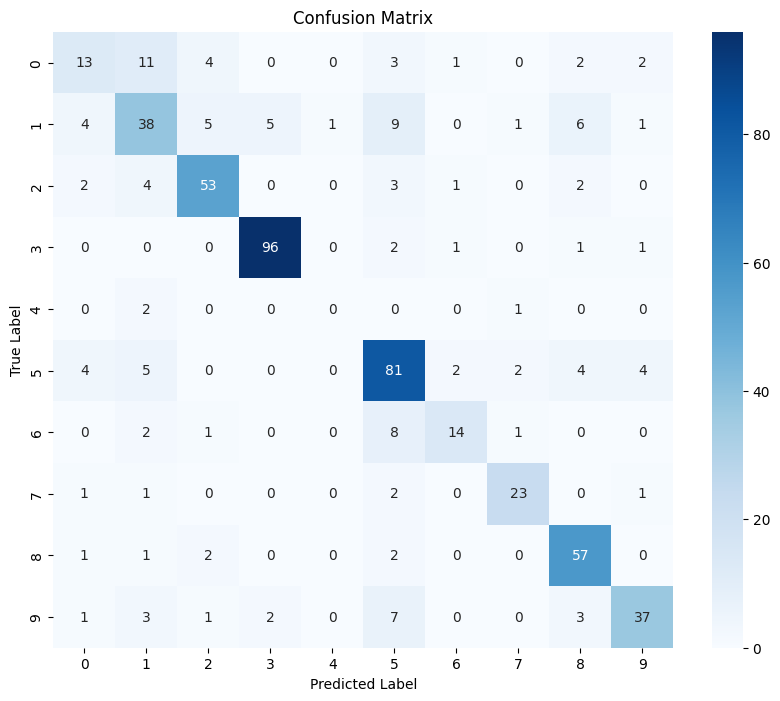

In [171]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    log_loss,
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Plot the loss values for train and test datasets
plt.figure(figsize=(10, 6))
plt.plot(evals_result["train"]["mlogloss"], label="Train Log-Loss")
plt.plot(evals_result["test"]["mlogloss"], label="Test Log-Loss")
plt.xlabel("Number of Boosting Rounds")
plt.ylabel("Log-Loss")
plt.title("Log-Loss During Training")
plt.legend()
plt.show()



# Print detailed metrics
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")
weighted_f1 = f1_score(y_test, y_pred, average="weighted")
macro_precision = precision_score(y_test, y_pred, average="macro")
macro_recall = recall_score(y_test, y_pred, average="macro")

print("\nAdditional Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()